In [1]:
import sys
sys.path.append('../')

import numpy as np
import pandas as pd

from utils import get_pairwise_p_values
from survival import survival_curves
from plotting import scna_manhattan_plot

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.sans-serif'] = 'Arial'

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Data

In [2]:
tcga_clinical_df = pd.read_csv('../data/tcga_train_clinical_data.csv', index_col=0)
cv_predictions_df = pd.read_excel('../data/supplemental_tables.xlsx', sheet_name='Supplementary Table 5', index_col=0)

# Figure 4A

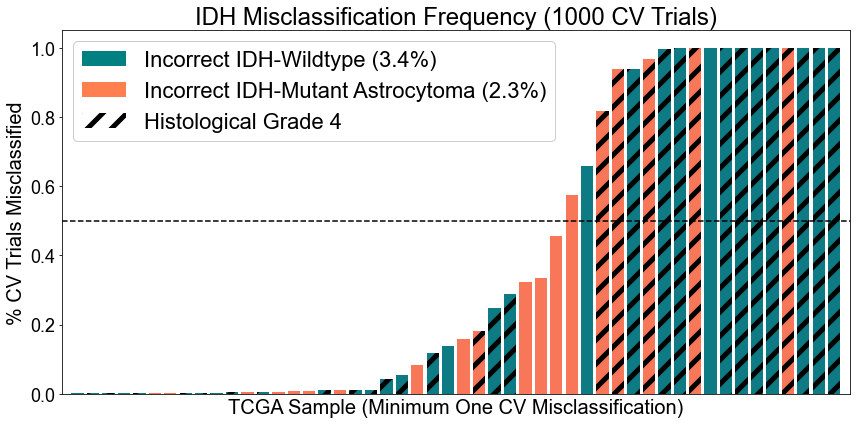

In [3]:
### find frequent misclassifed examples
_plot_df =  cv_predictions_df.loc[cv_predictions_df['Avg Misclassified'] > 0][['Avg Misclassified', 'IDH Mutation Status']]
_plot_df = pd.concat([_plot_df, tcga_clinical_df['Histologic_Grade']], axis=1, join='inner')
_plot_df = _plot_df.sort_values('Avg Misclassified').reset_index()

## make plot ##
fig, ax = plt.subplots(figsize=(12, 6))
barlist = ax.bar(_plot_df['index'], _plot_df['Avg Misclassified'])
plt.xticks(rotation = 90)
plt.axhline(y=0.5, linestyle='--', color='black')

color_dict = {'c_wt':'#2b3a41', 'w_wt':'#0e7a84', 'w_mut':'#f87758', 'c_mut':'#edca4a'}

import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 5.0  # previous svg hatch linewidth
    
for i in _plot_df.loc[_plot_df['IDH Mutation Status'] == 'IDH-Wildtype Glioblastoma'].index:
    barlist[i].set_facecolor('teal')
    barlist[i].set_facecolor(color_dict['w_wt'])
    
for i in _plot_df.loc[_plot_df['IDH Mutation Status'] == 'IDH-Mutant Astrocytoma'].index:
    barlist[i].set_facecolor('coral')
    barlist[i].set_facecolor(color_dict['w_mut'])
    
for i in _plot_df.loc[_plot_df['Histologic_Grade'] == 'G4'].index:
    barlist[i].set_hatch('/')
    barlist[i].set_linewidth(5)
    
# precentage inorrect 
# wildtype
w_wt_idxs = cv_predictions_df.loc[(cv_predictions_df['IDH Mutation Status'] == 'IDH-Wildtype Glioblastoma') 
                                  & (cv_predictions_df['Avg Misclassified'] > 0.5)].index
wt_idxs = cv_predictions_df.loc[(cv_predictions_df['IDH Mutation Status'] == 'IDH-Wildtype Glioblastoma')].index
w_wt_prec = str(np.round((len(w_wt_idxs)/len(wt_idxs)),3)*100)[:3] + '%'

# mutant
w_mut_idxs = cv_predictions_df.loc[(cv_predictions_df['IDH Mutation Status'] == 'IDH-Mutant Astrocytoma') 
                                   & (cv_predictions_df['Avg Misclassified'] > 0.5)].index
mut_idxs = cv_predictions_df.loc[(cv_predictions_df['IDH Mutation Status'] == 'IDH-Mutant Astrocytoma')].index
w_mut_prec = str(np.round(len(w_mut_idxs)/len(mut_idxs),3)*100) + '%'

import matplotlib.patches as mpatches
circ1 = mpatches.Patch( facecolor='teal',alpha=1,hatch='',label=u'Incorrect IDH-Wildtype ('+w_wt_prec+')')
circ2= mpatches.Patch( facecolor='coral',alpha=1,hatch='',label=u'Incorrect IDH-Mutant Astrocytoma ('+w_mut_prec+')')
circ3 = mpatches.Patch(facecolor='white',alpha=1,hatch='/',label='Histological Grade 4')
ax.legend(handles = [circ1,circ2,circ3], fontsize=22, bbox_to_anchor=(0.00,1), loc="upper left", framealpha=1)

plt.title('IDH Misclassification Frequency (1000 CV Trials)', fontsize=24)
plt.xlabel('TCGA Sample (Minimum One CV Misclassification)', fontsize=20)
plt.ylabel('% CV Trials Misclassified', fontsize=20)
plt.yticks(fontsize=18)
plt.xticks(fontsize=14)
plt.xticks([])
plt.xlim(-1, len(_plot_df))

plt.tight_layout()

In [4]:
w_wt_idxs = cv_predictions_df.loc[(cv_predictions_df['IDH Mutation Status'] == 'IDH-Wildtype Glioblastoma') 
                                  & (cv_predictions_df['Avg Misclassified'] > 0.5)].index
wt_idxs = cv_predictions_df.loc[(cv_predictions_df['IDH Mutation Status'] == 'IDH-Wildtype Glioblastoma')].index
w_wt_prec = str(np.round((len(w_wt_idxs)/len(wt_idxs)),3)*100)[:3] + '%'

print(str(len(w_wt_idxs)) +'/' + str(len(wt_idxs)), w_wt_prec)

12/358 3.4%


In [5]:
w_mut_idxs = cv_predictions_df.loc[(cv_predictions_df['IDH Mutation Status'] == 'IDH-Mutant Astrocytoma') 
                                   & (cv_predictions_df['Avg Misclassified'] > 0.5)].index
mut_idxs = cv_predictions_df.loc[(cv_predictions_df['IDH Mutation Status'] == 'IDH-Mutant Astrocytoma')].index
w_mut_prec = str(np.round(len(w_mut_idxs)/len(mut_idxs),3)*100) + '%'
print(str(len(w_mut_idxs)) +'/' + str(len(mut_idxs)), w_mut_prec)

6/257 2.3%


# Figure 4B

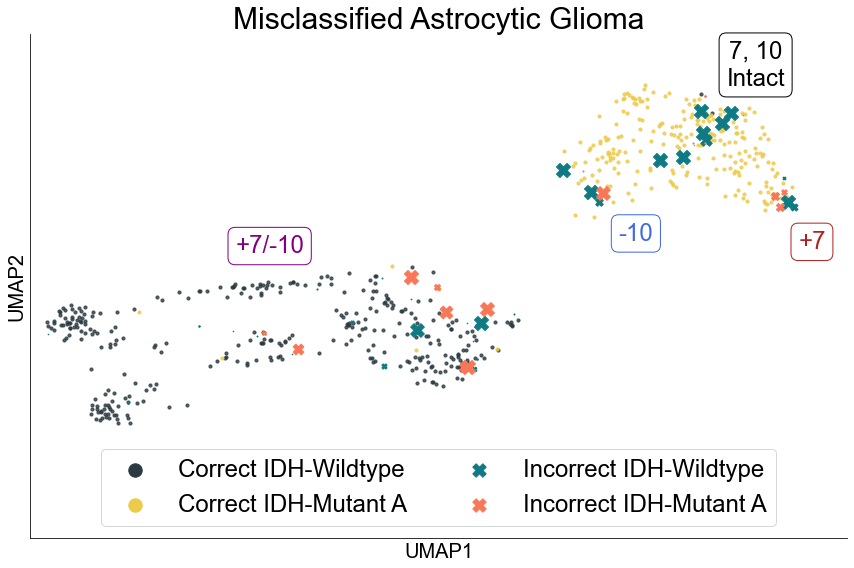

In [6]:
### Make Plot Data ###
plot_umap_df = pd.read_csv('../data/umap_astros_615.csv', index_col=0)
cv_predictions_idxs = [x for x in cv_predictions_df.index if x in plot_umap_df.index]

plot_umap_df.loc[cv_predictions_idxs, 'Avg Misclassified'] = cv_predictions_df.loc[cv_predictions_idxs]['Avg Misclassified'].values
plot_umap_df['IDH Mutation Status'] = np.nan
plot_umap_df.loc[cv_predictions_idxs, 'IDH Mutation Status'] = cv_predictions_df.loc[cv_predictions_idxs]['IDH Mutation Status'].values

### Plot ###
fig, ax = plt.subplots(figsize=(12,8))

## Correct Predictions
# wildtypes
_plot_df = plot_umap_df.loc[(plot_umap_df['IDH Mutation Status'] == 'IDH-Wildtype Glioblastoma') & (plot_umap_df['Avg Misclassified'] == 0)]
plt.scatter(_plot_df['umap1'], _plot_df['umap2'], alpha=0.8, s=10, color=color_dict['c_wt'], marker='o', label='Correct IDH-Wildtype')

# mutants
_plot_df = plot_umap_df.loc[(plot_umap_df['IDH Mutation Status'] == 'IDH-Mutant Astrocytoma') & (plot_umap_df['Avg Misclassified'] == 0)]
plt.scatter(_plot_df['umap1'], _plot_df['umap2'], alpha=0.8, s=10, color=color_dict['c_mut'], marker='o', label='Correct IDH-Mutant A')
    
## IDH wildtype
_plot_df = plot_umap_df.loc[(plot_umap_df['IDH Mutation Status'] == 'IDH-Wildtype Glioblastoma') & (plot_umap_df['Avg Misclassified'] > 0)]
for i, cnt in enumerate(_plot_df['Avg Misclassified'].unique()):
    _temp_plot_df = _plot_df.loc[_plot_df['Avg Misclassified'] == cnt]
    plt.scatter(_temp_plot_df['umap1'], _temp_plot_df['umap2'], alpha=1, s=cnt*200, color=color_dict['w_wt'], marker='X', 
                label='Incorrect IDH-Wildtype' if i == 0 else "")
    
## IDH Mutants
_plot_df = plot_umap_df.loc[(plot_umap_df['IDH Mutation Status'] == 'IDH-Mutant Astrocytoma') & (plot_umap_df['Avg Misclassified'] > 0)]
for i, cnt in enumerate(_plot_df['Avg Misclassified'].unique()):
    _temp_plot_df = _plot_df.loc[_plot_df['Avg Misclassified'] == cnt]
    plt.scatter(_temp_plot_df['umap1'], _temp_plot_df['umap2'], alpha=1, s=cnt*200, color=color_dict['w_mut'], marker='X', 
                label='Incorrect IDH-Mutant A' if i == 0 else "")
    
leg = plt.legend(fontsize=24, ncol=2, loc='lower center', bbox_to_anchor=(0.5, 0))
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    lh._sizes = [180]

props = dict(boxstyle='round,pad=0.3', facecolor='white', alpha=1, edgecolor='purple')
plt.text(x = 11.3, y=4.8, s='+7/-10', color='purple', fontsize=24, horizontalalignment='center', bbox=props)

props = dict(boxstyle='round,pad=0.3', facecolor='white', alpha=1, edgecolor='royalblue')
plt.text(x = 16.5, y=5.1, s='-10', color='royalblue', fontsize=24, horizontalalignment='center', bbox=props)

props = dict(boxstyle='round,pad=0.3', facecolor='white', alpha=1, edgecolor='firebrick')
plt.text(x = 19, y=4.9, s='+7', color='firebrick', fontsize=24, horizontalalignment='center', bbox=props)

props = dict(boxstyle='round,pad=0.3', facecolor='white', alpha=1, edgecolor='black')
plt.text(x = 18.2, y=8.8, s='7, 10\nIntact', color='black', fontsize=24, horizontalalignment='center', bbox=props)

ax.spines['right'].set_visible(False) # ['right', 'top']
ax.spines['top'].set_visible(False) # ['right', 'top']

plt.title('Misclassified Astrocytic Glioma', fontsize=30)
plt.xlabel('UMAP1', fontsize=20)
plt.ylabel('UMAP2', fontsize=20)
plt.ylim(-2,10)
plt.xlim(7.9,19.5)

plt.xticks([])
plt.yticks([])
plt.tight_layout()

# Sup Figure 4A

In [7]:
# Somatic copy number alteration (SCNA) data
!wget -P ../data/ https://tcga-xena-hub.s3.us-east-1.amazonaws.com/download/TCGA.GBMLGG.sampleMap%2FGistic2_CopyNumber_Gistic2_all_thresholded.by_genes.gz

--2021-12-06 12:26:19--  https://tcga-xena-hub.s3.us-east-1.amazonaws.com/download/TCGA.GBMLGG.sampleMap%2FGistic2_CopyNumber_Gistic2_all_thresholded.by_genes.gz
Resolving tcga-xena-hub.s3.us-east-1.amazonaws.com (tcga-xena-hub.s3.us-east-1.amazonaws.com)... 52.217.170.58
Connecting to tcga-xena-hub.s3.us-east-1.amazonaws.com (tcga-xena-hub.s3.us-east-1.amazonaws.com)|52.217.170.58|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1804219 (1.7M) [binary/octet-stream]
Saving to: ‘../data/TCGA.GBMLGG.sampleMap%2FGistic2_CopyNumber_Gistic2_all_thresholded.by_genes.gz.5’

TCGA.GBMLGG.sampleM 100%[===================>]   1.72M  2.22MB/s    in 0.8s    

2021-12-06 12:26:21 (2.22 MB/s) - ‘../data/TCGA.GBMLGG.sampleMap%2FGistic2_CopyNumber_Gistic2_all_thresholded.by_genes.gz.5’ saved [1804219/1804219]



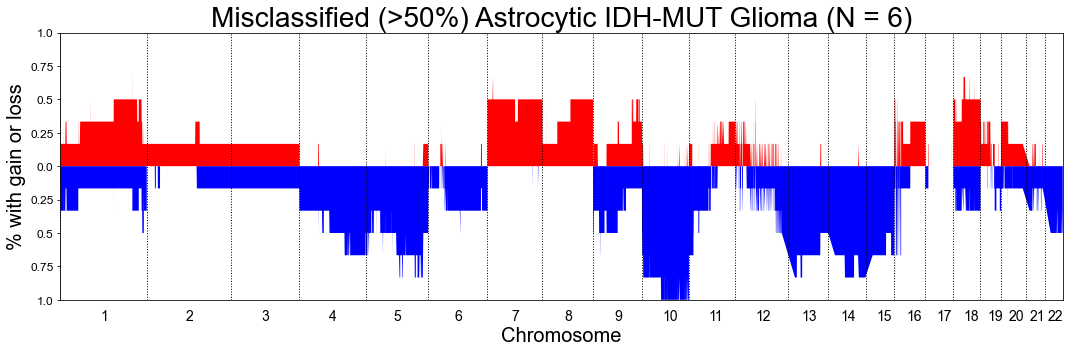

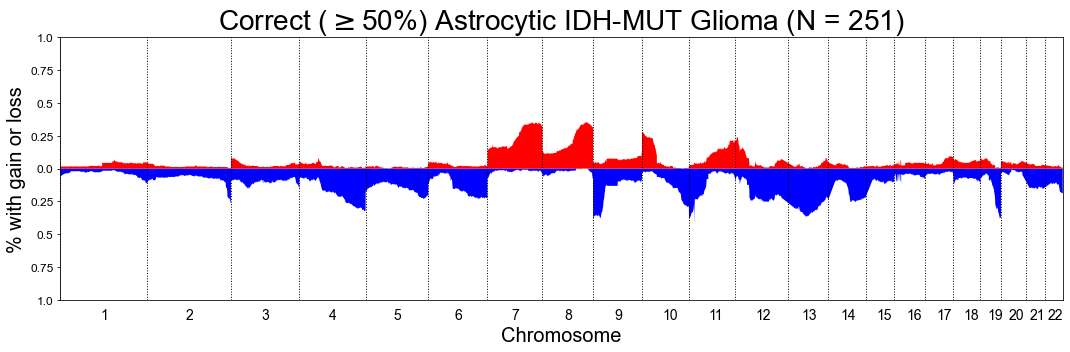

In [8]:
figsize = (15,5)
# using UCSC hg19 data for data size convenience 
scna_filepath = '../data/TCGA.GBMLGG.sampleMap%2FGistic2_CopyNumber_Gistic2_all_thresholded.by_genes.gz'
manhattan_scna_df = pd.read_csv(scna_filepath, sep='\t', index_col=0).T
manhattan_scna_df.index = manhattan_scna_df.index.str[:-3]
manhattan_gene_loc_df = pd.read_csv('../data/manhattan_gene_loc.csv', index_col=0)

# misclassified MUTs
idxs = cv_predictions_df.loc[(cv_predictions_df['IDH Mutation Status'] == 'IDH-Mutant Astrocytoma') 
                             & (cv_predictions_df['Avg Misclassified'] > 0.5)].index
save, outfile = False, None

title = 'Misclassified (>50%) Astrocytic IDH-MUT Glioma (N = ' + str(len(idxs)) +')'
outfile = '../figures/manhattan_plots/mutant_scna_profile.pdf'
chroms = [str(i+1) for i in range(22)]# + ['X']

plot_df1 = scna_manhattan_plot(scna_df=manhattan_scna_df.loc[idxs], 
                                          gene_loc_df=manhattan_gene_loc_df.dropna(),
                                          chroms=chroms,
                                          exclude_genes=[],
                                          title=title,
                                          ylim=1.0,
                                          chrom_label_size=14,
                                          tick_size=12,
                                          chrom_label_ypos=-1.15,
                                          xlabel = '\nChromosome',
                                          save=save,
                                          title_size=28,
                                          outfile=outfile,
                                          figsize=figsize)


# misclassified MUTs
idxs = cv_predictions_df.loc[(cv_predictions_df['IDH Mutation Status'] == 'IDH-Mutant Astrocytoma') 
                             & (cv_predictions_df['Avg Misclassified'] <= 0.5)].index
save, outfile = False, None

title = r'Correct ($\geq$50%) Astrocytic IDH-MUT Glioma (N = ' + str(len(idxs)) +')'
outfile = '../figures/manhattan_plots/mutant_scna_profile.pdf'
chroms = [str(i+1) for i in range(22)]# + ['X']

plot_df1 = scna_manhattan_plot(scna_df=manhattan_scna_df.loc[idxs], 
                                          gene_loc_df=manhattan_gene_loc_df.dropna(),
                                          chroms=chroms,
                                          exclude_genes=[],
                                          title=title,
                                          ylim=1.0,
                                          chrom_label_size=14,
                                          tick_size=12,
                                          chrom_label_ypos=-1.15,
                                          xlabel = '\nChromosome',
                                          save=save,
                                          title_size=28,
                                          outfile=outfile,
                                          figsize=figsize)


# Sup Figure 4B

get predictions . . . 
correct_mut_idxs: 251
incorrect_mut_idxs: 6
plot 1 . . . .
240 1 11 5
fisher exact = 2.8109646228078696e-06


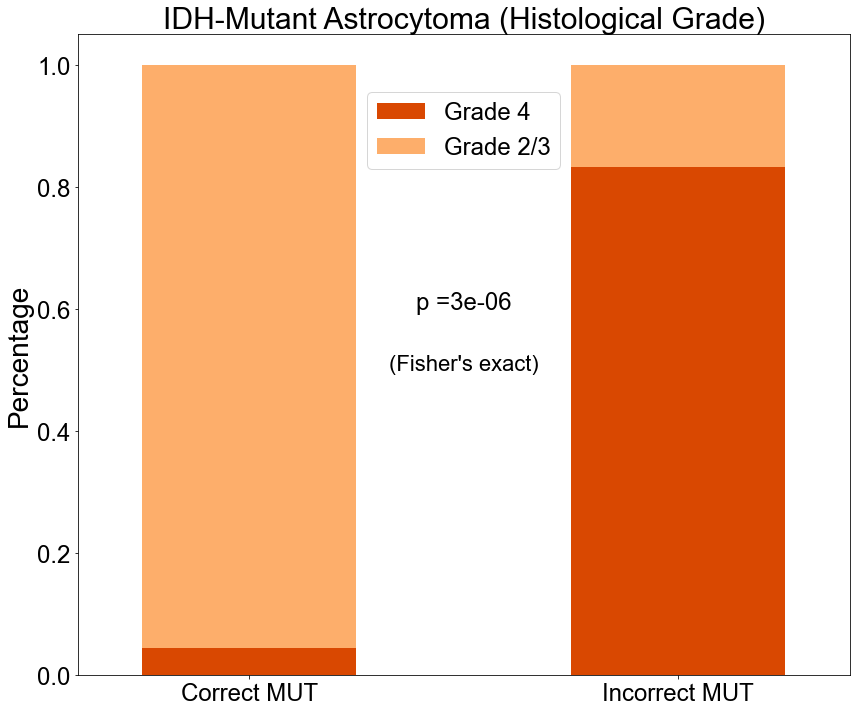

In [9]:
print('get predictions . . . ')
error_thresh = 0.5
correct_mut_idxs = cv_predictions_df.loc[(cv_predictions_df['Avg Misclassified'] <= error_thresh) 
                      & (cv_predictions_df['IDH Mutation Status'] == 'IDH-Mutant Astrocytoma')].index
print('correct_mut_idxs:', len(correct_mut_idxs))

incorrect_mut_idxs = cv_predictions_df.loc[(cv_predictions_df['Avg Misclassified'] > error_thresh) 
                      & (cv_predictions_df['IDH Mutation Status'] == 'IDH-Mutant Astrocytoma')].index
print('incorrect_mut_idxs:', len(incorrect_mut_idxs))

## plot histological grade distribution ##
print('plot 1 . . . .')
# wildtypes
## Build DataFrame ####
lgg_idxs = tcga_clinical_df.loc[tcga_clinical_df['Histologic_Grade'] != 'G4'].index
g4_idxs = tcga_clinical_df.loc[tcga_clinical_df['Histologic_Grade'] == 'G4'].index

lgg_correct_mut_idxs = [x for x in correct_mut_idxs if x in lgg_idxs]
lgg_incorrect_mut_idxs = [x for x in incorrect_mut_idxs if x in lgg_idxs]
g4_correct_mut_idxs = [x for x in correct_mut_idxs if x in g4_idxs]
g4_incorrect_mut_idxs = [x for x in incorrect_mut_idxs if x in g4_idxs]

print(len(lgg_correct_mut_idxs), len(lgg_incorrect_mut_idxs), len(g4_correct_mut_idxs), len(g4_incorrect_mut_idxs))

# data
data_df = pd.DataFrame(data=[[len(g4_correct_mut_idxs), len(g4_incorrect_mut_idxs)],
                             [len(lgg_correct_mut_idxs), len(lgg_incorrect_mut_idxs)], ], 
                       index=['Grade 4', 'Grade 2/3'],
                       columns=[u'Correct MUT', u'Incorrect MUT'])

## Plot ##
save = False
# df_temp = (data_df.T/data_df.T.sum(axis=0)).T
df_temp = (data_df/data_df.sum(axis=0)).T

df_temp.plot.bar(stacked=True, figsize=(12, 10), color=['#d94801', '#fdae6b'])
plt.title('IDH-Mutant Astrocytoma (Histological Grade)', fontsize=30)
plt.xticks(rotation=0, fontsize=24)
plt.yticks(fontsize=24)
plt.ylabel('Percentage', fontsize=28)
plt.legend(fontsize=24, bbox_to_anchor=(0.5,0.85), loc="center")
plt.xlim(-0.4,1.4)

## fisher's exact test
import scipy.stats as stats
oddsratio, pvalue = stats.fisher_exact(data_df.values)
print('fisher exact =', pvalue)
plt.text(x = 0.5, y=0.6, s='p ='+str(np.round(pvalue, 6)), color='black', fontsize=24, horizontalalignment='center')
plt.text(x = 0.5, y=0.5, s="(Fisher's exact)", color='black', fontsize=22, horizontalalignment='center')
##

plt.tight_layout()

218 1 33 5
fisher exact = 0.0002986306165531805


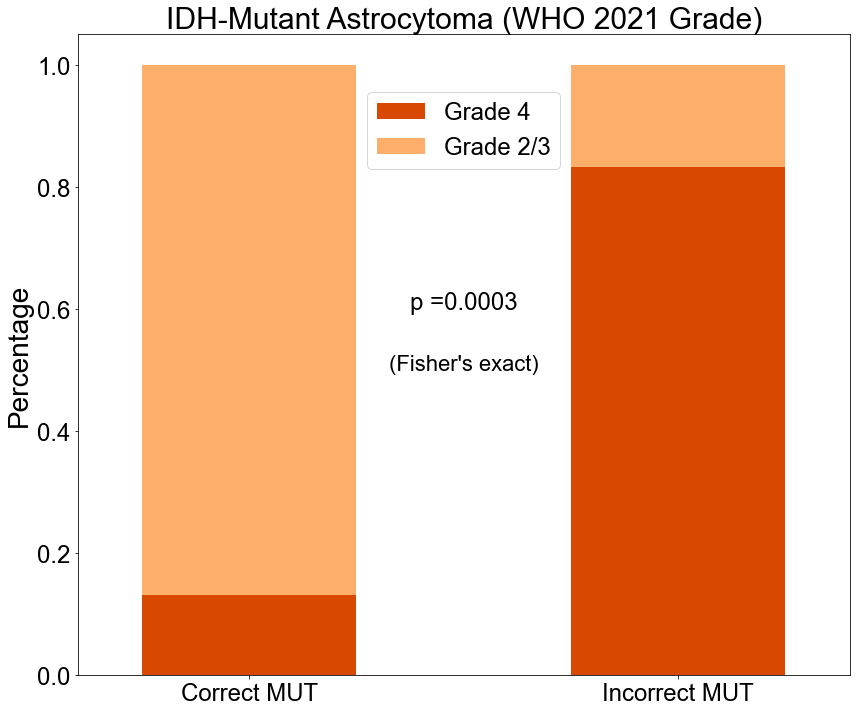

In [10]:
lgg_idxs = tcga_clinical_df.loc[tcga_clinical_df['WHO_2021_Grade'] != 'G4'].index
g4_idxs = tcga_clinical_df.loc[tcga_clinical_df['WHO_2021_Grade'] == 'G4'].index

lgg_correct_mut_idxs = [x for x in correct_mut_idxs if x in lgg_idxs]
lgg_incorrect_mut_idxs = [x for x in incorrect_mut_idxs if x in lgg_idxs]
g4_correct_mut_idxs = [x for x in correct_mut_idxs if x in g4_idxs]
g4_incorrect_mut_idxs = [x for x in incorrect_mut_idxs if x in g4_idxs]

print(len(lgg_correct_mut_idxs), len(lgg_incorrect_mut_idxs), len(g4_correct_mut_idxs), len(g4_incorrect_mut_idxs))

# data
data_df = pd.DataFrame(data=[[len(g4_correct_mut_idxs), len(g4_incorrect_mut_idxs)],
                             [len(lgg_correct_mut_idxs), len(lgg_incorrect_mut_idxs)]], 
                       index=['Grade 4', 'Grade 2/3'],
                       columns=[u'Correct MUT', u'Incorrect MUT'])

## Plot ##
save = False
# df_temp = (data_df.T/data_df.T.sum(axis=0)).T
df_temp = (data_df/data_df.sum(axis=0)).T
df_temp.plot.bar(stacked=True, figsize=(12, 10), color=['#d94801', '#fdae6b'])
plt.title('IDH-Mutant Astrocytoma (WHO 2021 Grade)', fontsize=30)
plt.xticks(rotation=0, fontsize=24)
plt.yticks(fontsize=24)
plt.ylabel('Percentage', fontsize=28)
plt.legend(fontsize=24, bbox_to_anchor=(0.5,0.85), loc="center")
plt.xlim(-0.4,1.4)

## fisher's exact test
import scipy.stats as stats
oddsratio, pvalue = stats.fisher_exact(data_df.values)
print('fisher exact =', pvalue)
plt.text(x = 0.5, y=0.6, s='p ='+str(np.round(pvalue, 5)), color='black', fontsize=24, horizontalalignment='center')
plt.text(x = 0.5, y=0.5, s="(Fisher's exact)", color='black', fontsize=22, horizontalalignment='center')
##

plt.tight_layout()

# Sup Figure 4C

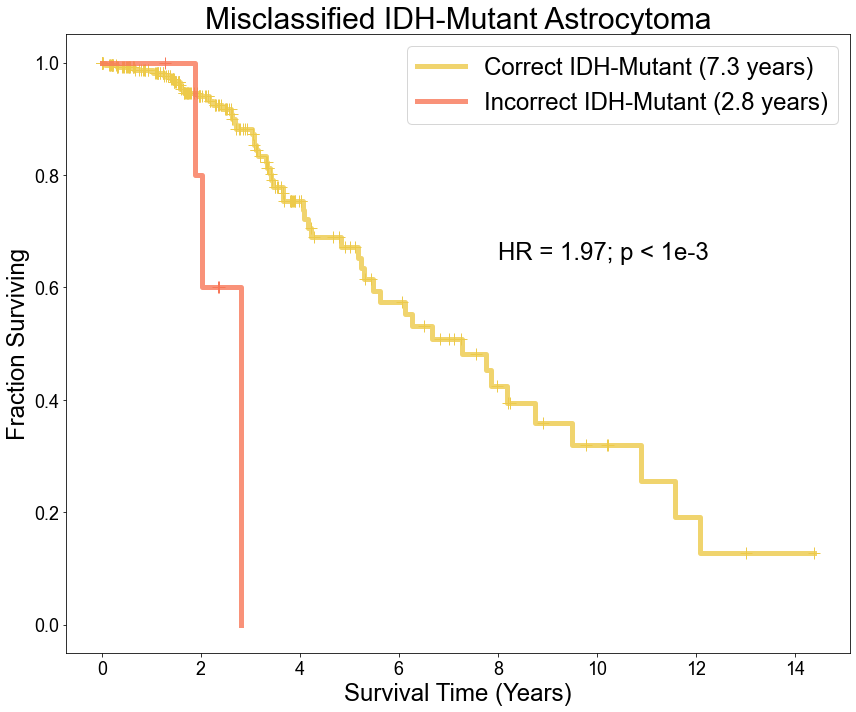

,p-value
"('Correct IDH-Mutant', 'Incorrect IDH-Mutant')",0.000258


In [11]:
save = False; outfile = None

error_thresh = 0.5
correct_mut_idxs = cv_predictions_df.loc[(cv_predictions_df['Avg Misclassified'] <= error_thresh) 
                      & (cv_predictions_df['IDH Mutation Status'] == 'IDH-Mutant Astrocytoma')].index.tolist()
incorrect_mut_idxs = cv_predictions_df.loc[(cv_predictions_df['Avg Misclassified'] > error_thresh) 
                      & (cv_predictions_df['IDH Mutation Status'] == 'IDH-Mutant Astrocytoma')].index.tolist()

idxs = correct_mut_idxs + incorrect_mut_idxs
label_df = pd.DataFrame(index=idxs, columns=['label'])
label_df.loc[correct_mut_idxs, 'label'] = 'Correct IDH-Mutant'
label_df.loc[incorrect_mut_idxs, 'label'] = 'Incorrect IDH-Mutant'
exclude_labels = []

temp_style_dict = {}
temp_style_dict['Correct IDH-Mutant'] = {'color': color_dict['c_mut'], 'linestyle': '-', 'alpha': 0.8, 'linewidth': 5, 's': 60}
temp_style_dict['Incorrect IDH-Mutant'] = {'color': color_dict['w_mut'], 'linestyle': '-', 'alpha': 0.8, 'linewidth': 5, 's': 60}

title = 'Misclassified IDH-Mutant Astrocytoma'
kmf_df = pd.concat([tcga_clinical_df[['OS', 'OS_EVENT']], label_df], axis=1, join='inner')

save = False
result_df = survival_curves(kmf_df, 
                            title=title, 
                            save=save, 
                            outfile=outfile, 
                            show_p_value=True,
                            text_xpos=8, 
                            p_size=24,
                            text_ypos=0.65,
                            ci_show=False,
                            legend_size=24,
                            show_longtail=False,
                            exclude_labels=exclude_labels,
                            p_longtail=0.2,
                            pval_dec=3,
                            style_dict=temp_style_dict,
                            figsize=(12,10),
                            hr_replace_dict={'Correct IDH-Mutant':0, 'Incorrect IDH-Mutant':1},
                            titlesize=30,
                            show_hr=True)
get_pairwise_p_values(result_df['kmf'])

# Sup Figure 4D

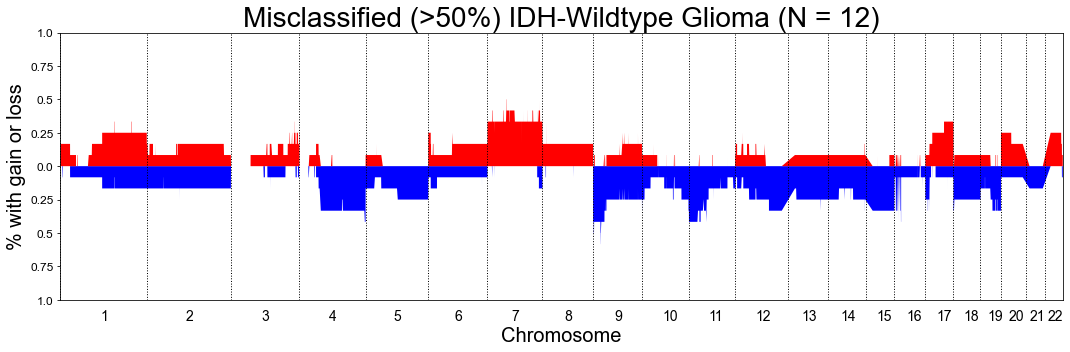

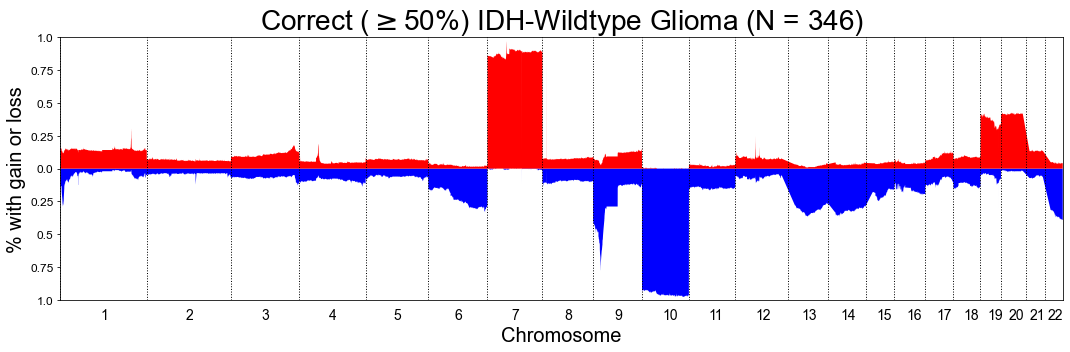

In [12]:
figsize = (15,5)
# using UCSC hg19 data for data size convenience 
scna_filepath = '../data/TCGA.GBMLGG.sampleMap%2FGistic2_CopyNumber_Gistic2_all_thresholded.by_genes.gz'
manhattan_scna_df = pd.read_csv(scna_filepath, sep='\t', index_col=0).T
manhattan_scna_df.index = manhattan_scna_df.index.str[:-3]
manhattan_gene_loc_df = pd.read_csv('../data/manhattan_gene_loc.csv', index_col=0)

# misclassified WTs
idxs = cv_predictions_df.loc[(cv_predictions_df['IDH Mutation Status'] == 'IDH-Wildtype Glioblastoma') 
                             & (cv_predictions_df['Avg Misclassified'] > 0.5)].index

title = 'Misclassified (>50%) IDH-Wildtype Glioma (N = ' + str(len(idxs)) +')'
outfile = '../figures/manhattan_plots/mutant_scna_profile.pdf'
chroms = [str(i+1) for i in range(22)]# + ['X']

save, outfile = False, None
plot_df1 = scna_manhattan_plot(scna_df=manhattan_scna_df.loc[idxs], 
                                          gene_loc_df=manhattan_gene_loc_df.dropna(),
                                          chroms=chroms,
                                          exclude_genes=[],
                                          title=title,
                                          ylim=1.0,
                                          chrom_label_size=14,
                                          tick_size=12,
                                          chrom_label_ypos=-1.15,
                                          xlabel = '\nChromosome',
                                          save=save,
                                          title_size=28,
                                          outfile=outfile,
                                          figsize=figsize)


# correct WTs
idxs = cv_predictions_df.loc[(cv_predictions_df['IDH Mutation Status'] == 'IDH-Wildtype Glioblastoma') 
                             & (cv_predictions_df['Avg Misclassified'] <= 0.5)].index

title = r'Correct ($\geq$50%) IDH-Wildtype Glioma (N = ' + str(len(idxs)) +')'
outfile = '../figures/manhattan_plots/mutant_scna_profile.pdf'
chroms = [str(i+1) for i in range(22)]# + ['X']

save, outfile = False, None
plot_df1 = scna_manhattan_plot(scna_df=manhattan_scna_df.loc[idxs], 
                                          gene_loc_df=manhattan_gene_loc_df.dropna(),
                                          chroms=chroms,
                                          exclude_genes=[],
                                          title=title,
                                          ylim=1.0,
                                          chrom_label_size=14,
                                          tick_size=12,
                                          chrom_label_ypos=-1.15,
                                          xlabel = '\nChromosome',
                                          save=save,
                                          title_size=28,
                                          outfile=outfile,
                                          figsize=figsize)

# Sup Figure 4E

correct_wt_idxs: 346
incorrect_wt_idxs: 12
68 2 278 10
fisher exact = 1.0


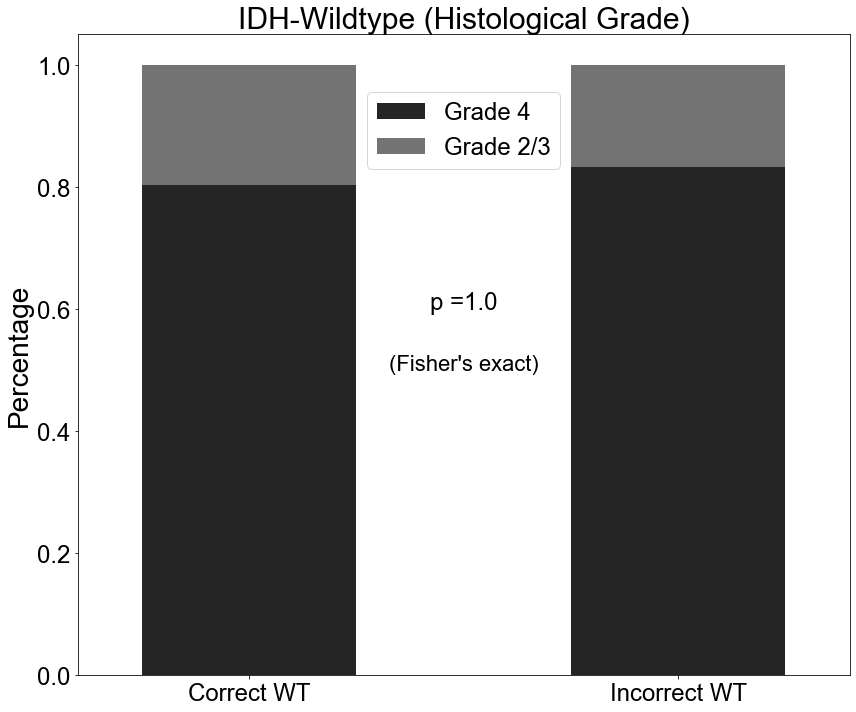

In [13]:
error_thresh = 0.5
correct_wt_idxs = cv_predictions_df.loc[(cv_predictions_df['Avg Misclassified'] <= error_thresh) 
                      & (cv_predictions_df['IDH Mutation Status'] == 'IDH-Wildtype Glioblastoma')].index
print('correct_wt_idxs:', len(correct_wt_idxs))

incorrect_wt_idxs = cv_predictions_df.loc[(cv_predictions_df['Avg Misclassified'] > error_thresh) 
                      & (cv_predictions_df['IDH Mutation Status'] == 'IDH-Wildtype Glioblastoma')].index
print('incorrect_wt_idxs:', len(incorrect_wt_idxs))

# wildtypes
## Build DataFrame ####
lgg_idxs = tcga_clinical_df.loc[tcga_clinical_df['Histologic_Grade'] != 'G4'].index
g4_idxs = tcga_clinical_df.loc[tcga_clinical_df['Histologic_Grade'] == 'G4'].index

lgg_correct_wt_idxs = [x for x in correct_wt_idxs if x in lgg_idxs]
lgg_incorrect_wt_idxs = [x for x in incorrect_wt_idxs if x in lgg_idxs]
g4_correct_wt_idxs = [x for x in correct_wt_idxs if x in g4_idxs]
g4_incorrect_wt_idxs = [x for x in incorrect_wt_idxs if x in g4_idxs]

print(len(lgg_correct_wt_idxs), len(lgg_incorrect_wt_idxs), len(g4_correct_wt_idxs), len(g4_incorrect_wt_idxs))

# data
data_df = pd.DataFrame(data=[[len(g4_correct_wt_idxs), len(g4_incorrect_wt_idxs)],
                             [len(lgg_correct_wt_idxs), len(lgg_incorrect_wt_idxs)]
                            ], 
                       index=['Grade 4', 'Grade 2/3'],
                       columns=[u'Correct WT', u'Incorrect WT'])
## Plot ##
save = False
df_temp = (data_df/data_df.sum(axis=0)).T
df_temp.plot.bar(stacked=True, figsize=(12, 10), color=['#252525', '#737373'])
plt.title('IDH-Wildtype (Histological Grade)', fontsize=30)
plt.xticks(rotation=0, fontsize=24)
plt.yticks(fontsize=24)
plt.ylabel('Percentage', fontsize=28)
plt.legend(fontsize=24, bbox_to_anchor=(0.5,0.85), loc="center")
plt.xlim(-0.4,1.4)

## fisher's exact test
import scipy.stats as stats
oddsratio, pvalue = stats.fisher_exact(data_df.values)
print('fisher exact =', pvalue)
plt.text(x = 0.5, y=0.6, s='p ='+str(np.round(pvalue, 5)), color='black', fontsize=24, horizontalalignment='center')
plt.text(x = 0.5, y=0.5, s="(Fisher's exact)", color='black', fontsize=22, horizontalalignment='center')
##

plt.tight_layout()

# Sup Figure 4F

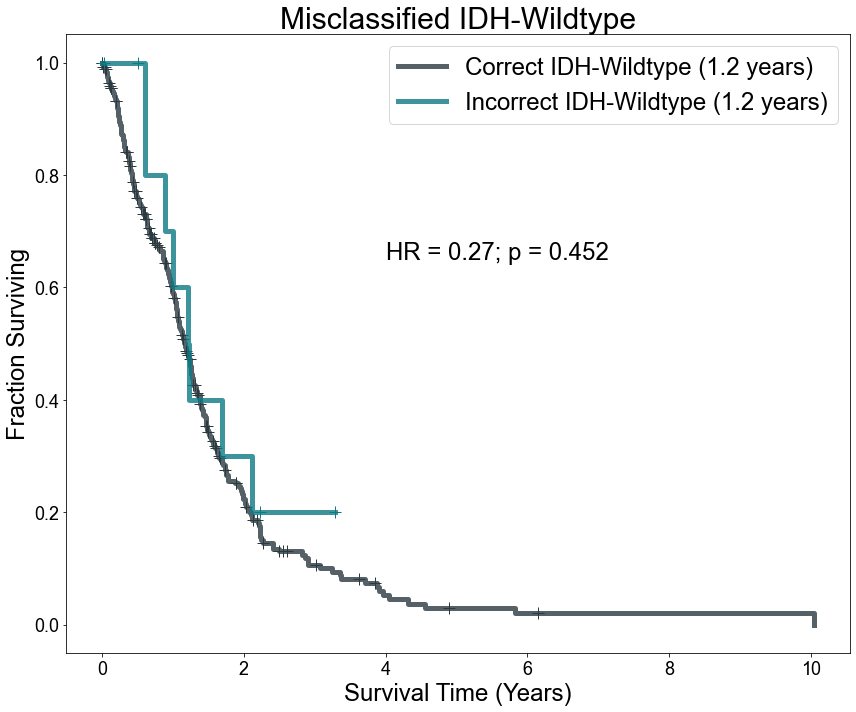

,p-value
"('Correct IDH-Wildtype', 'Incorrect IDH-Wildtype')",0.451965


In [14]:
save = False; outfile = None

error_thresh = 0.5
correct_wt_idxs = cv_predictions_df.loc[(cv_predictions_df['Avg Misclassified'] <= error_thresh) 
                      & (cv_predictions_df['IDH Mutation Status'] == 'IDH-Wildtype Glioblastoma')].index.tolist()
incorrect_wt_idxs = cv_predictions_df.loc[(cv_predictions_df['Avg Misclassified'] > error_thresh) 
                      & (cv_predictions_df['IDH Mutation Status'] == 'IDH-Wildtype Glioblastoma')].index.tolist()

idxs = correct_wt_idxs + incorrect_wt_idxs
label_df = pd.DataFrame(index=idxs, columns=['label'])
label_df.loc[correct_wt_idxs, 'label'] = 'Correct IDH-Wildtype'
label_df.loc[incorrect_wt_idxs, 'label'] = 'Incorrect IDH-Wildtype'
exclude_labels = []

temp_style_dict = {}
temp_style_dict['Correct IDH-Wildtype'] = {'color': color_dict['c_wt'], 'linestyle': '-', 'alpha': 0.8, 'linewidth': 5, 's': 60}
temp_style_dict['Incorrect IDH-Wildtype'] = {'color': color_dict['w_wt'], 'linestyle': '-', 'alpha': 0.8, 'linewidth': 5, 's': 60}

title = 'Misclassified IDH-Wildtype'
kmf_df = pd.concat([tcga_clinical_df[['OS', 'OS_EVENT']], label_df], axis=1, join='inner')

save, outfile = False, None
result_df = survival_curves(kmf_df, 
                            title=title, 
                            save=save, 
                            outfile=outfile, 
                            show_p_value=True,
                            text_xpos=4, 
                            p_size=24,
                            text_ypos=0.65,
                            ci_show=False,
                            legend_size=24,
                            show_longtail=False,
                            exclude_labels=exclude_labels,
                            p_longtail=0.2,
                            pval_dec=3,
                            style_dict=temp_style_dict,
                            figsize=(12,10),
                            hr_replace_dict={'Incorrect IDH-Wildtype':0, 'Correct IDH-Wildtype':1},
                            titlesize=30,
                            show_hr=True)
get_pairwise_p_values(result_df['kmf'])